In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyrosm.data import sources
from pyrosm import get_data
from pyrosm import OSM
from shapely.ops import nearest_points

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
fp = get_data('Moscow')
# fp = 'RU-LEN.osm.pbf'

In [3]:
osm = OSM(fp)

In [4]:
msk_parks = osm.get_data_by_custom_criteria(
    custom_filter={'leisure': ['park', 'garden'], 'natural': ['wood']},
    filter_type='keep',
    keep_nodes = False,
    keep_ways = True,
    keep_relations=True
)

<AxesSubplot:>

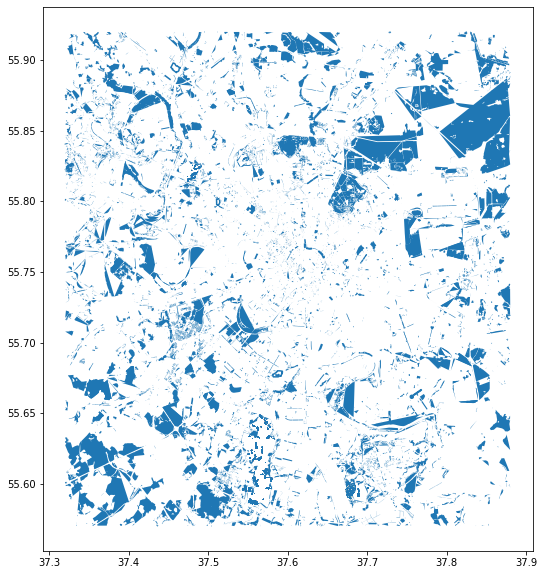

In [5]:
msk_parks.plot(figsize=(10, 10))

In [6]:
my_filter = {"highway": ["trunk", "primary", "secondary"]}

drive_net = osm.get_data_by_custom_criteria(custom_filter=my_filter)

<AxesSubplot:>

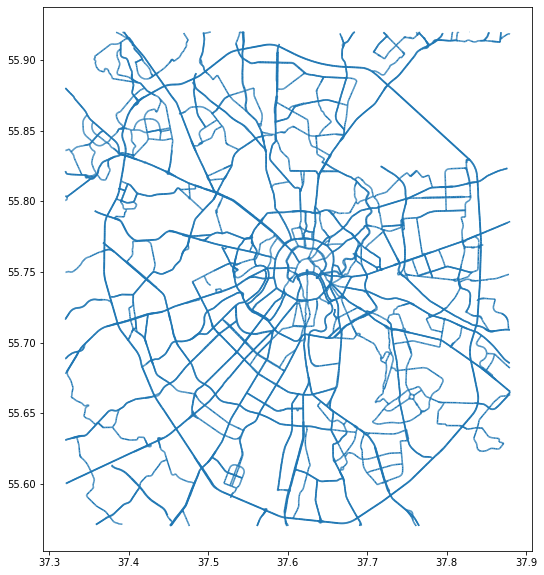

In [7]:
drive_net.plot(figsize=(10,10))

In [8]:
sensors = pd.read_csv('sensors.csv')

In [9]:
sensors = sensors[37.32<=sensors.lon]
sensors = sensors[sensors.lon<=37.89]
sensors = sensors[55.55<=sensors.lat]
sensors = sensors[sensors.lat<=55.93]

In [10]:
sensors = gpd.GeoDataFrame(sensors, geometry=gpd.points_from_xy(sensors.lon, sensors.lat))
sensors['geometry'] = sensors.geometry.set_crs(epsg=4326)

<AxesSubplot:>

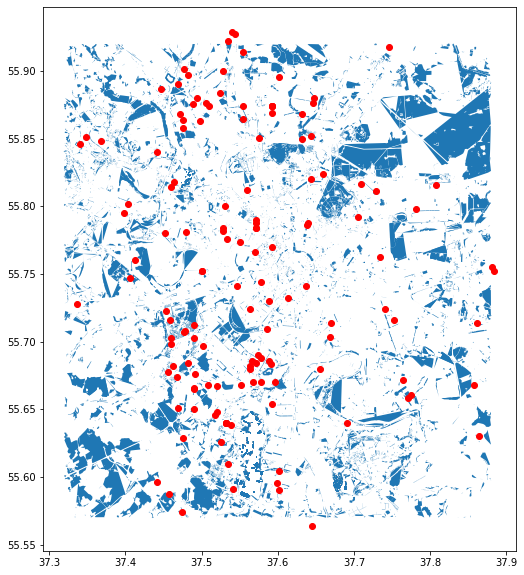

In [11]:
ax = msk_parks.plot(figsize=(10,10))
sensors.plot(ax=ax, color='red')

In [12]:
def nearest(row, geom):
    nearest = nearest_points(row, geom)[1]
    return nearest

In [13]:
union = msk_parks.centroid.unary_union

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [14]:
sensors['nearest_park'] = sensors.geometry.apply(nearest, geom=union)

In [15]:
sensors['nearest_park'] = sensors.geometry.to_crs("EPSG:3395").distance(sensors.nearest_park.to_crs("EPSG:3395"))

In [16]:
drive_union = drive_net.geometry.unary_union

In [17]:
sensors['nearest_road'] = sensors.geometry.apply(nearest, geom=drive_union)

In [18]:
sensors['nearest_road'] = sensors.geometry.to_crs("EPSG:3395").distance(sensors.nearest_road.to_crs("EPSG:3395"))

(<AxesSubplot:>, <AxesSubplot:>)

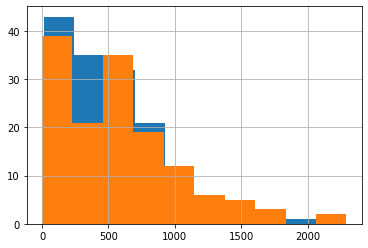

In [19]:
sensors.nearest_park.hist(), sensors.nearest_road.hist()

In [20]:
sensors.head()

,sds_sensor,bme_sensor,lat,lon,sealevel,surface_alt,surface_level,geometry,nearest_park,nearest_road
0,43811,43812,55.703017,37.459441,198.271350,163.0,35.271350,POINT (37.45944 55.70302),27.477373,112.194727
1,46280,46281,55.677867,37.456325,179.684930,176.0,3.684930,POINT (37.45633 55.67787),63.665823,864.642229
2,33626,33627,55.874089,37.510001,167.960469,176.0,-8.039531,POINT (37.51000 55.87409),302.209884,1014.471402
3,54815,54816,55.752000,37.884000,236.385167,153.0,83.385167,POINT (37.88400 55.75200),2284.548750,966.684916
4,45568,45569,55.625773,37.525268,263.580603,230.0,33.580603,POINT (37.52527 55.62577),746.952071,1411.553491
